# **MODELLING AND EVALUATION**

## Objectives

* Find the most efficient algorithm for regression , fine tune it and validate it.
* Validate hypothesis

## Inputs

* Data cleaning pipeline and feature engineering pipeline

## Outputs

* End to end ML pipeline, which is validated and ready for deployment
* pipeline versions
* train and test set - features and target

## Additional Comments
 
 * Pipeline versions saved at outputs/datasets/predict_price/


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/pp5_project_heritage_housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/pp5_project_heritage_housing'

---

# Initial Set up

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_price_records.csv") 

print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


**Split data into train and test set**

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1) ,
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


**Import necessary modules and data**

In [6]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import RandomSampleImputer

### Feature Engineering
from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**Combine data cleaning and feature engineering pipeline steps and add model as a last step**

In [7]:
# Pipeline optimization
def PipelineOptimization(model):
  pipeline_base = Pipeline([
    # Data cleaning (copied from Data Cleaning notebook)
     ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF']) ),
    ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='None',
                                     variables=['GarageFinish']) ),
    ( 'random_sample',  RandomSampleImputer(
                                     variables=['LotFrontage' ,
                                     'BsmtFinType1','2ndFlrSF','MasVnrArea']) ),
    ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['BedroomAbvGr']) ),

    # Feature engineering (copied from Feature Engineering notebook)
    ( 'OrdinalCategoricalEncoder', OrdinalEncoder(encoding_method='arbitrary',
                                                variables = ['BsmtExposure',
                                                            'BsmtFinType1',
                                                            'GarageFinish',
                                                            'KitchenQual'])),
    ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=3, tail='both', 
                                                  variables=['1stFlrSF',
                                                            'GarageArea',
                                                            'GrLivArea',
                                                            'YearBuilt',
                                                            'TotalBsmtSF',]) ),
    
    ("feat_scaling", StandardScaler() ),

    ("model", model ),
    ])

  return pipeline_base

---

# Look for most optimal ML algorithm 

For that, we will use a custom function and GridSearchCV. For hyperparameters, we will use parameters suggested by official documentation as a starting point

We will igore linear regression model to begin with, because our data cleaning and feature engineering pipeline is simpl and contains correlated features that can affect its prediction. Tree based and ensamble methods are more tolerant to that.

In [8]:
models_quick_search = {
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

# From Scikit-learn Unit 6
params_quick_search = {

    "DecisionTreeRegressor": {'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "RandomForestRegressor": {'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "ExtraTreesRegressor": {'model__n_estimators': [100,50,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },

    "AdaBoostRegressor": {'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                          'model__loss':['linear', 'square', 'exponential'],
        },

    "GradientBoostingRegressor": {'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
        },

    "XGBRegressor": {'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
        },
}

Let's use these two functions as agruments to the following code that will help us to find most suitable model.

The code is taken from walkthrough project 2 notebook

In [9]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

Let's search for most suitable model.

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

---

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
201,GradientBoostingRegressor,0.778216,0.8628,0.904536,0.051113,15,None,50,50,100,0.1,NaN,NaN
239,GradientBoostingRegressor,0.773874,0.862545,0.908059,0.053011,None,50,50,50,140,0.1,NaN,NaN
176,GradientBoostingRegressor,0.778083,0.862355,0.905305,0.051474,3,None,50,2,140,0.1,NaN,NaN
198,GradientBoostingRegressor,0.778787,0.86234,0.904398,0.050469,15,None,50,2,100,0.1,NaN,NaN
222,GradientBoostingRegressor,0.775694,0.862179,0.906554,0.052148,None,None,50,2,100,0.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,XGBRegressor,-6.295558,-5.088201,-4.387221,0.643301,None,NaN,NaN,NaN,30,0.001,NaN,0
408,XGBRegressor,-6.29569,-5.088205,-4.387221,0.643359,15,NaN,NaN,NaN,30,0.001,NaN,0
435,XGBRegressor,-6.296173,-5.088308,-4.387221,0.643538,15,NaN,NaN,NaN,30,0.001,NaN,0.1
405,XGBRegressor,-6.306933,-5.089831,-4.385802,0.648195,3,NaN,NaN,NaN,30,0.001,NaN,0


Looks like GradientBoostinRegressor performs the best on mean_score. The score is 0.86 , which is above the target of 0.75.

In [12]:
best_model= grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

216 different combinations were tried when the code above was run. So, I belive the model is optimised for now and we don't need to do additional tuning. (However, uder  performance on test set can warrant having a second look. We will check that soon)

In [13]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 15,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

Let's check the model performance on test set after defining pipeline

In [14]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt',
                                                'WoodDeckSF'])),
                ('categorical',
                 CategoricalImputer(fill_value='None',
                                    variables=['GarageFinish'])),
                ('random_sample',
                 RandomSampleImputer(variables=['LotFrontage', 'BsmtFinType1',
                                                '2ndFlrSF', 'MasVnrArea'])),
                ('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['B...
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', tail='both',
                            variables=['1stFlrSF', 'GarageArea', 'GrLivArea',
                     

#### Performance check

Let's define a custom function (adopted from Scikit Learn Notebook) to evaluate performance on train and test set

In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  plt.savefig(f'docs/regression_plots/regression_performance.png', bbox_inches='tight')  
  plt.show()

Evaluate performance

Model Evaluation 

* Train Set
R2 Score: 0.933
Mean Absolute Error: 10135.05
Mean Squared Error: 412897853.703
Root Mean Squared Error: 20319.888


* Test Set
R2 Score: 0.81
Mean Absolute Error: 19668.192
Mean Squared Error: 1314219016.694
Root Mean Squared Error: 36252.159




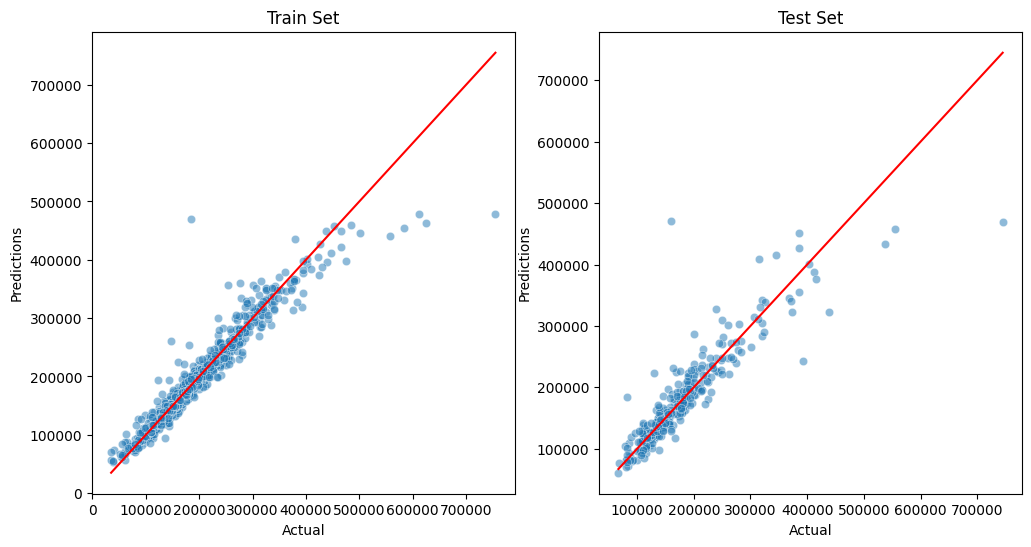

In [16]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

- R2 score for Train set is 0.94 and for Test set is 0.81 , both of them are above the threshold of 0.75

- R2 score on Train set indicates overfitting. Let's se if we can do some hyperparameter tuning.

Save first version of pipeline

In [17]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/regression_pipeline.pkl")

[Errno 17] File exists: 'outputs/ml_pipeline/predict_price/v1'


['outputs/ml_pipeline/predict_price/v1/regression_pipeline.pkl']

#### Hyper parameter tuning

The R2 score difference between Test and Train set is 0.13. 

Let's attempt to reduce that by understanding the model and playing with hyper parameter tuning.

In [19]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}
params_search = {
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.1],
        'model__max_depth': [15],   # changing model max_depth from None to 4 to prevent complexity
        'model__n_estimators': [140]
        }
}

In [20]:
# Refit the pipeline

# search for algo and hyper parameters
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

# save result matrix
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Model Evaluation 

* Train Set
R2 Score: 0.998
Mean Absolute Error: 583.709
Mean Squared Error: 13764210.251
Root Mean Squared Error: 3710.015


* Test Set
R2 Score: 0.76
Mean Absolute Error: 25371.59
Mean Squared Error: 1654359965.815
Root Mean Squared Error: 40673.824




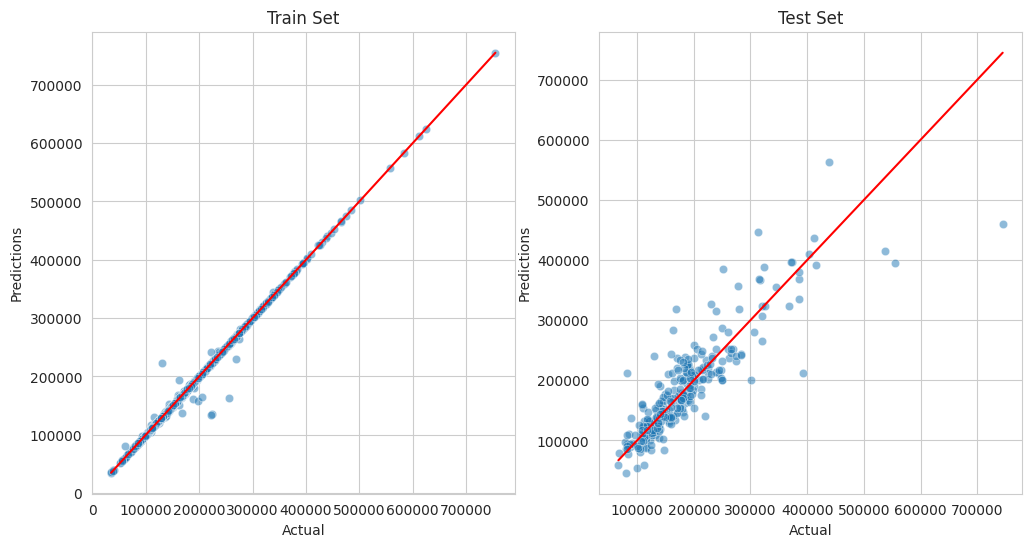

In [62]:
# extract best model and its parameters with
best_model= grid_search_summary.iloc[0,0]
best_parameters = grid_search_pipelines[best_model].best_params_

# get the best pipeline
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_

# check its regression performance
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Looks like deeper the model, the more it overfits. Let's limit the model max depth by trying some lower numbers along with larger n estimator.


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Model Evaluation 

* Train Set
R2 Score: 0.927
Mean Absolute Error: 12243.495
Mean Squared Error: 446403897.011
Root Mean Squared Error: 21128.272


* Test Set
R2 Score: 0.813
Mean Absolute Error: 19758.908
Mean Squared Error: 1293078304.207
Root Mean Squared Error: 35959.398




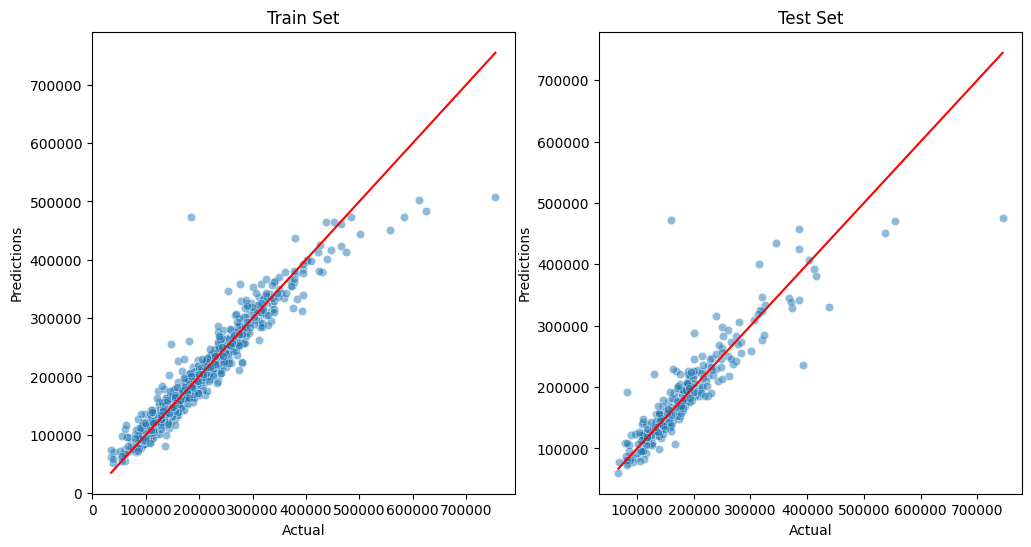

In [21]:
params_search = {
        "GradientBoostingRegressor": {    
        'model__learning_rate': [0.05, 0.1],    # attempting slower learning rate
        'model__max_depth': [3, 4, 5],          # limiting model max depth                  
        'model__min_samples_leaf': [50, 100],   
        'model__min_samples_split': [2, 10],
        'model__n_estimators': [140, 200]       # trying higher n estimators
        },
}

# Refit the pipeline

# search for algo and hyper parameters
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

# save result matrix
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')

# extract best model and its parameters with
best_model= grid_search_summary.iloc[0,0]
best_parameters = grid_search_pipelines[best_model].best_params_

# get the best pipeline
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_

# check its regression performance
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

In [22]:
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 4,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

The previous R2 score for Train and Test were 0.94 and 0.81.

Now the R2 score for Train and Test set is 0.91 and 0.81 

Here, we reduced the model's max depth from None to 3 (or sometimes returns 4), which reduced the overfitting from 0.94 to 0.91. 

Other hyper parameters seems to be optimised enough.

Save second version of pipeline

In [32]:

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/regression_pipeline.pkl")

[Errno 17] File exists: 'outputs/ml_pipeline/predict_price/v2'


['outputs/ml_pipeline/predict_price/v2/regression_pipeline.pkl']

#### Rewrite pipeline with additional step - Feature selection

To reduce overfitting, we can consider adding "feature selection" as a pipeline step. Let's rewrite the entire pipeline with it

In [33]:
# Pipeline optimization
def PipelineOptimization(model):
  pipeline_base = Pipeline([
    # Data cleaning (copied from Data Cleaning notebook)
     ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF'])),
    ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='None',
                                     variables=['GarageFinish'])),
    ( 'random_sample',  RandomSampleImputer(
                                     variables=['LotFrontage' ,
                                     'BsmtFinType1','2ndFlrSF','MasVnrArea'])),
    ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['BedroomAbvGr']) ),

    # Feature engineering (copied from Feature Engineering notebook)
    ( 'OrdinalCategoricalEncoder', OrdinalEncoder(encoding_method='arbitrary',
                                                variables = ['BsmtExposure',
                                                            'BsmtFinType1',
                                                            'GarageFinish',
                                                            'KitchenQual'])),
    ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=3, tail='both', 
                                                  variables=['1stFlrSF',
                                                            'GarageArea',
                                                            'GrLivArea',
                                                            'YearBuilt',
                                                            'TotalBsmtSF',])),
    ("feat_scaling", StandardScaler()),
    ("feat_selection",  SelectFromModel(model, threshold="mean")),
    ("model", model),
    ])

  return pipeline_base

Let's rerun the pipeline and check the performance

In [34]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}
params_search = {
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.1],
        'model__max_depth': [3],
        'model__min_samples_leaf': [50],
        'model__min_samples_split': [2],
        'model__n_estimators': [140]}
}


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Model Evaluation 

* Train Set
R2 Score: 0.834
Mean Absolute Error: 21359.496
Mean Squared Error: 1024460750.793
Root Mean Squared Error: 32007.198


* Test Set
R2 Score: 0.761
Mean Absolute Error: 24327.455
Mean Squared Error: 1648795357.104
Root Mean Squared Error: 40605.361




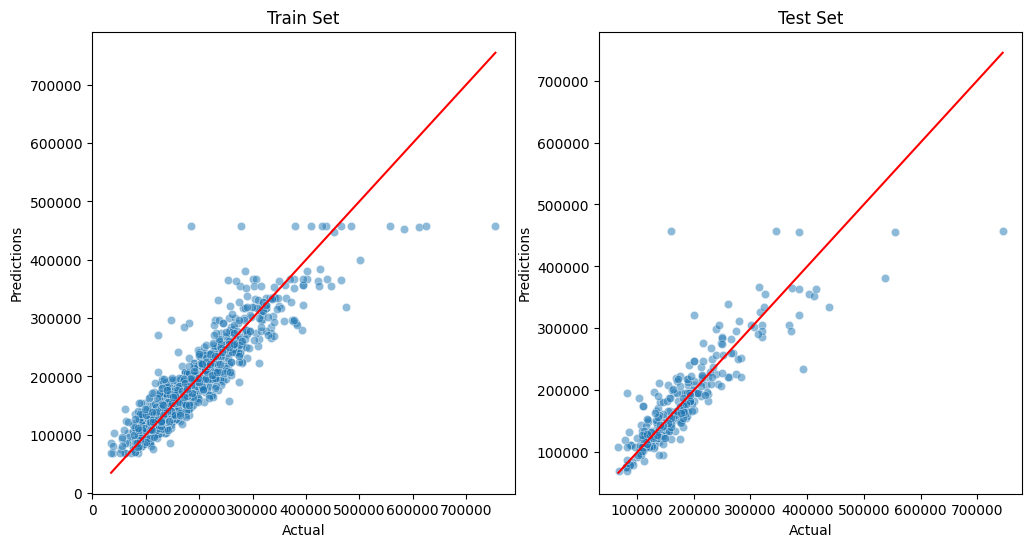

In [35]:
# search for algo and hyper parameters
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

# save result matrix
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')

# extract best model and its parameters with
best_model= grid_search_summary.iloc[0,0]
best_parameters = grid_search_pipelines[best_model].best_params_

# get the best pipeline
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_

# check its regression performance
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

save third version of pipeline

In [39]:

version = 'v3'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/regression_pipeline.pkl")

[Errno 17] File exists: 'outputs/ml_pipeline/predict_price/v3'


['outputs/ml_pipeline/predict_price/v3/regression_pipeline.pkl']

The R2 score for Train set are now much closer.

However, R2 score for test is 0.76  very close to criteria of 0.75

If we compare the R2 score of the pipeline without feature selection step, it is 0.81. 

That means feature selection step is filtering out far too many features. There is a possiblility the datset contains a few features with equal imporatace and some of them are not being passed on to model.

So, let's lower the threshold from default "mean" to "0.75*mean"

(official documentation : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Model Evaluation 

* Train Set
R2 Score: 0.874
Mean Absolute Error: 18440.661
Mean Squared Error: 776217034.132
Root Mean Squared Error: 27860.672


* Test Set
R2 Score: 0.791
Mean Absolute Error: 22597.931
Mean Squared Error: 1441570014.93
Root Mean Squared Error: 37968.013




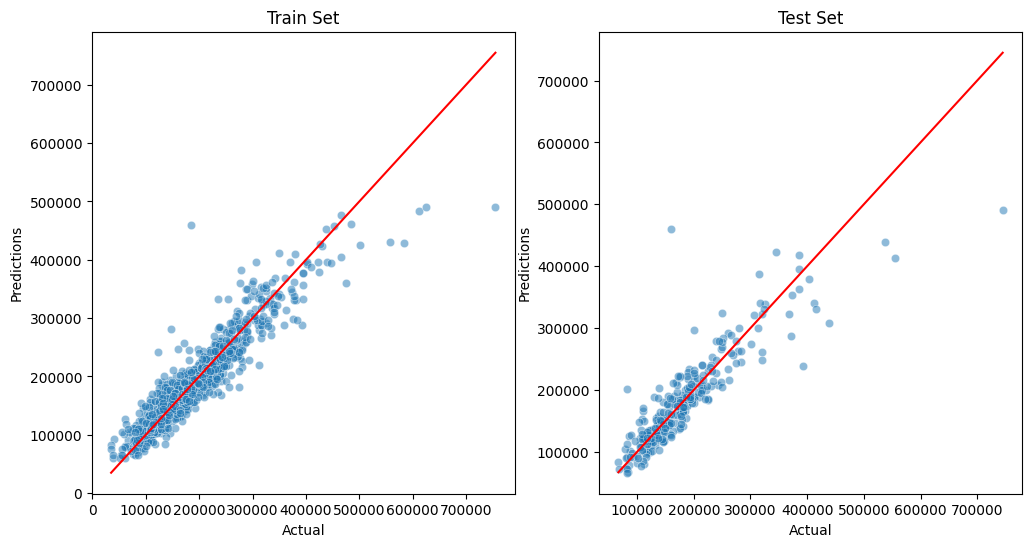

In [40]:
# Pipeline optimization
def PipelineOptimization(model):
  pipeline_base = Pipeline([
    # Data cleaning (copied from Data Cleaning notebook)
     ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF'])),
    ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='None',
                                     variables=['GarageFinish'])),
    ( 'random_sample',  RandomSampleImputer(
                                     variables=['LotFrontage' ,
                                     'BsmtFinType1','2ndFlrSF','MasVnrArea'])),
    ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['BedroomAbvGr']) ),

    # Feature engineering (copied from Feature Engineering notebook)
    ( 'OrdinalCategoricalEncoder', OrdinalEncoder(encoding_method='arbitrary',
                                                variables = ['BsmtExposure',
                                                            'BsmtFinType1',
                                                            'GarageFinish',
                                                            'KitchenQual'])),
    ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=3, tail='both', 
                                                  variables=['1stFlrSF',
                                                            'GarageArea',
                                                            'GrLivArea',
                                                            'YearBuilt',
                                                            'TotalBsmtSF',])),
    ("feat_scaling", StandardScaler()),
    ("feat_selection",  SelectFromModel(model, threshold="0.75*mean")), # reduced threshold
    ("model", model),
    ])

  return pipeline_base


# search for algo and hyper parameters
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

# save result matrix
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')

# extract best model and its parameters with
best_model= grid_search_summary.iloc[0,0]
best_parameters = grid_search_pipelines[best_model].best_params_

# get the best pipeline
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_

# check its regression performance
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

We will consider this an optimised version of pipeline as R2 score for test set is 0.79, which is higher than critera. But on the other side, we have tried reducing model overfitting. as much as possible.

Save third version of pipeline

In [41]:

version = 'v4'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_price/v4/regression_pipeline.pkl']

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1']


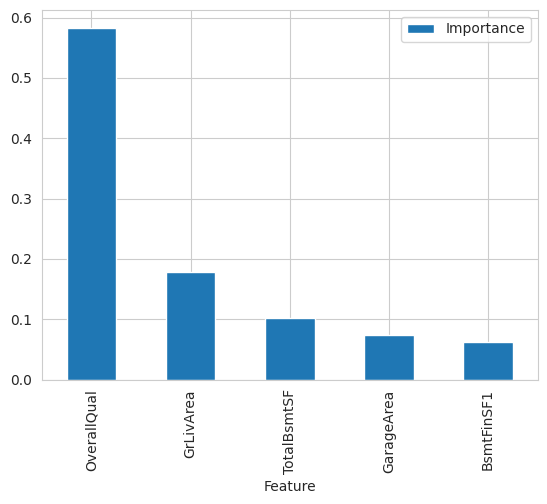

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 6
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

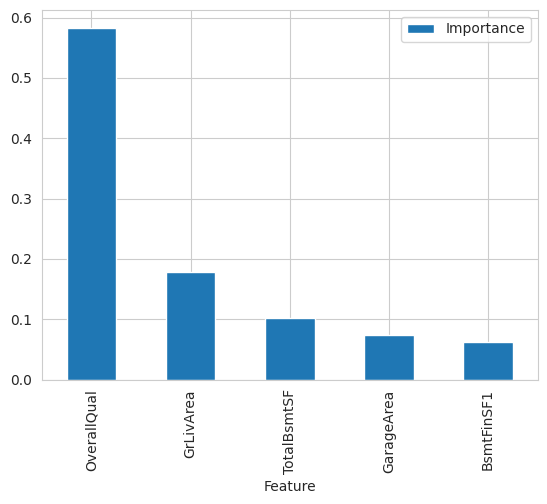

In [104]:
# save feature imporatnce plot

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')

## Save to docs folder for documentation
plt.savefig(f'docs/images/features_importance.png', bbox_inches='tight') 

---

# Conclusions

| **Pipeline**                                 	| **Version** 	| Mean R2  (Train) 	| Mean R2  (Test) 	| delta R2 	|
|----------------------------------------------	|-------------	|------------------	|-----------------	|----------	|
| gradientboost with default hyper param       	| v1          	| 0.94             	| 0.81            	| 0.13     	|
| parameter optimised                          	| v2          	| 0.91             	| 0.81            	| 0.10     	|
| additional feature selelection pipeline step 	| v3          	| 0.83             	| 0.76            	| 0.7      	|
| feature selection optimised                  	| v4          	| 0.87             	| 0.79            	| 0.8      	|

* Gradient boosting is the most efficient algorithm. The test set passes the critera of R2 score of 0.75 and above

* Hypothesis - bigger than property higher the price - Ture

* Hypothesis - higher the quality better the price - True

* Hypothesis - Newer the property higher the price - False (it does not impact as much as quality and size)